In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import predict_model
import time
from datetime import datetime
from datetime import timedelta
sns.set()

2024-11-08 00:14:53.250946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 00:14:53.419615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 00:14:53.479609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 00:14:53.636401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 00:15:07.490457: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv('/home/proj/finTF/store_data/process/OHLCV_info/calculate_total_year/건설업.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,날짜,시가,고가,저가,종가,거래량,거래대금,상장시가총액,MA_20,RSI_14,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
0,2019-01-02,114.16,114.28,109.52,109.68,7693718,131862463020,22968885353340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,110.26,111.39,108.48,109.74,6448039,135584034930,22980279078725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,109.69,110.75,107.63,110.53,6492409,120595944505,23142157126330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,112.57,113.99,111.38,112.85,6227272,141100772525,23624182838270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,113.76,114.82,111.25,112.04,18484435,160257389005,23454855772875,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 3].values.reshape((-1,1)))
close_normalize = minmax.transform(df.iloc[:, 3].values.reshape((-1,1))).reshape((-1))

In [4]:
close_normalize.shape

(1233,)

In [5]:
class encoder:
    def __init__(self, input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
        input_size = input_.shape[1]
        self.X = tf.placeholder("float", [None, input_.shape[1]])
    
        weights = {
        'encoder_h1': tf.Variable(tf.random_normal([input_size, hidden_layer])),
        'encoder_h2': tf.Variable(tf.random_normal([hidden_layer, dimension])),
        'decoder_h1': tf.Variable(tf.random_normal([dimension, hidden_layer])),
        'decoder_h2': tf.Variable(tf.random_normal([hidden_layer, input_size])),
        }
    
        biases = {
        'encoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'encoder_b2': tf.Variable(tf.random_normal([dimension])),
        'decoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'decoder_b2': tf.Variable(tf.random_normal([input_size])),
        }
    
        first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder_h1']), biases['encoder_b1']))
        self.second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
        first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
        second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector.shape


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2024-11-08 00:16:17.004325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch: 10 loss: 0.052675888 time: 0.034571170806884766
epoch: 20 loss: 0.0010443763 time: 0.05262136459350586
epoch: 30 loss: 0.0009164934 time: 0.0452265739440918
epoch: 40 loss: 0.00089929014 time: 0.03217005729675293
epoch: 50 loss: 0.00087144796 time: 0.04568910598754883
epoch: 60 loss: 0.00082755776 time: 0.057149648666381836
epoch: 70 loss: 0.00089228404 time: 0.044733524322509766
epoch: 80 loss: 0.14065671 time: 0.04005885124206543
epoch: 90 loss: 0.06675277 time: 0.06361126899719238
epoch: 100 loss: 0.07177109 time: 0.0633091926574707


(1233, 32)

In [7]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

In [8]:
ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(n_estimators=500)

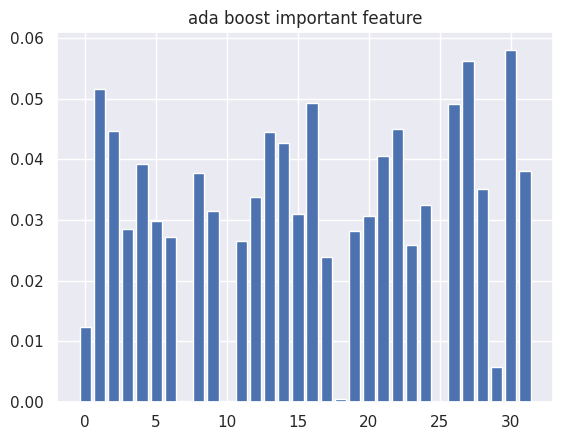

In [9]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

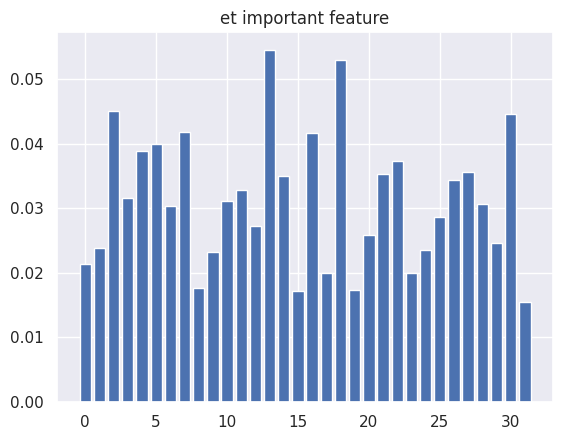

In [10]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()

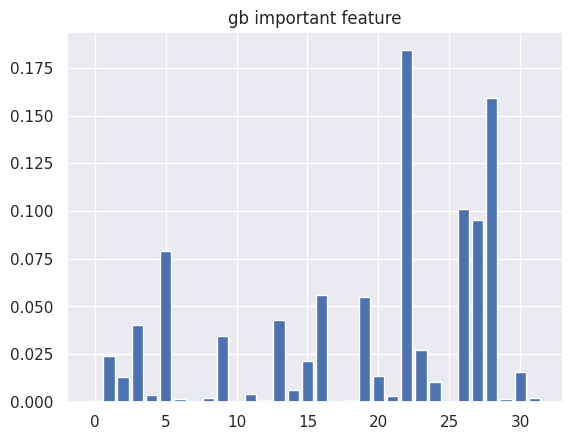

In [11]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

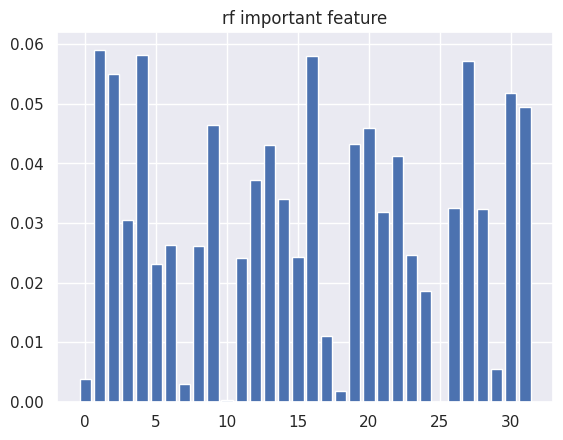

In [12]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

In [13]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

In [14]:
ada_actual = np.hstack([close_normalize[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,close_normalize]).T
corr_df = pd.DataFrame(stack_predict)

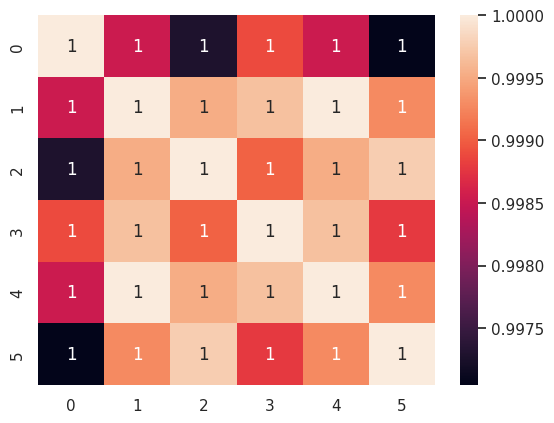

In [15]:
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

In [16]:
import xgboost as xgb
train_Y = close_normalize[1:]

# DMatrix로 데이터를 변환, train_Y를 label로 포함
dtrain = xgb.DMatrix(stack_predict[:-1, :], label=train_Y)

# 파라미터 설정
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'eval_metric': 'rmse'
}

# 모델 학습
clf = xgb.train(
    params=params_xgd,
    dtrain=dtrain,
    num_boost_round=10000,
    evals=[(dtrain, 'train')],
    early_stopping_rounds=20,
    verbose_eval=False
)


In [17]:
# stack_predict를 DMatrix로 변환하여 예측 수행
dstack_predict = xgb.DMatrix(stack_predict)
xgb_pred = clf.predict(dstack_predict)

# 예측 결과를 사용하여 xgb_actual 생성
xgb_actual = np.hstack([close_normalize[0], xgb_pred[:-1]])

# 날짜 형식을 원하는 포맷으로 변환
date_original = pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()


In [18]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

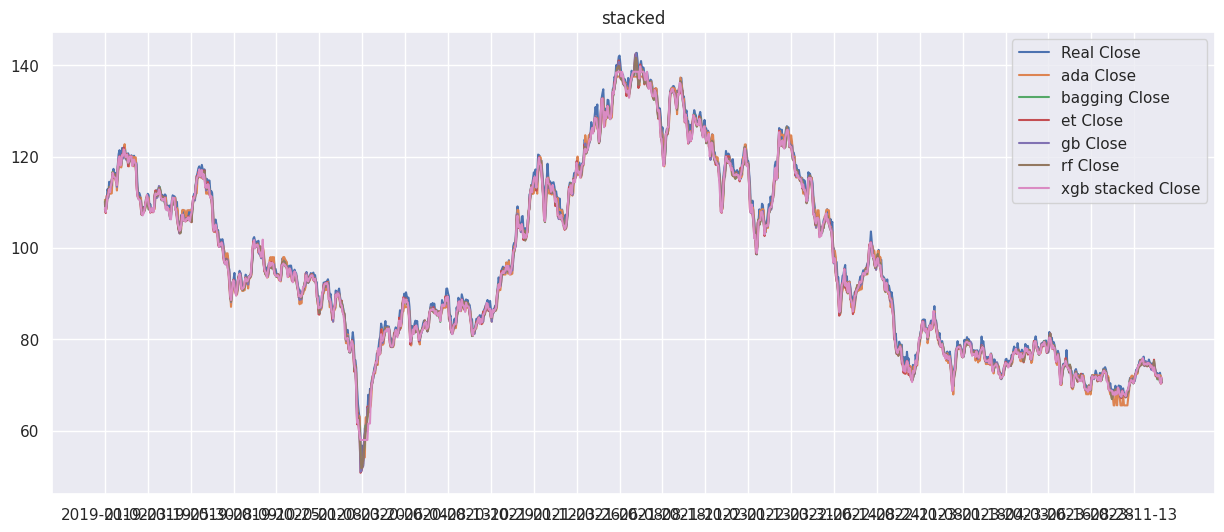

In [19]:
plt.figure(figsize = (15,6))
x_range = np.arange(df["종가"].shape[0])
plt.plot(x_range, df["종가"], label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::50], date_original[::50])
plt.title('stacked')
plt.show()

In [20]:
ada_list = ada_pred.tolist()
bagging_list = bagging_pred.tolist()
et_list = et_pred.tolist()
gb_list = gb_pred.tolist()
rf_list = rf_pred.tolist()
xgb_list = xgb_pred.tolist()


# 업데이트된 predict 함수
def predict(count, history=5):
    for i in range(count):
        # xgb_list의 마지막 history 개수 추출
        roll = np.array(xgb_list[-history:])
        thought_vector = Encoder.encode(roll.reshape((-1, 1)))

        # 각 모델의 예측
        ada_pred = ada.predict(thought_vector)
        bagging_pred = bagging.predict(thought_vector)
        et_pred = et.predict(thought_vector)
        gb_pred = gb.predict(thought_vector)
        rf_pred = rf.predict(thought_vector)

        # 예측 결과를 각 리스트에 추가
        ada_list.append(ada_pred[-1])
        bagging_list.append(bagging_pred[-1])
        et_list.append(et_pred[-1])
        gb_list.append(gb_pred[-1])
        rf_list.append(rf_pred[-1])

        # stack_predict 생성
        ada_actual = np.hstack([xgb_list[-history], ada_pred[:-1]])
        bagging_actual = np.hstack([xgb_list[-history], bagging_pred[:-1]])
        et_actual = np.hstack([xgb_list[-history], et_pred[:-1]])
        gb_actual = np.hstack([xgb_list[-history], gb_pred[:-1]])
        rf_actual = np.hstack([xgb_list[-history], rf_pred[:-1]])
        stack_predict = np.vstack([ada_actual, bagging_actual, et_actual, gb_actual, rf_actual, xgb_list[-history:]]).T

        # stack_predict를 DMatrix로 변환 후 예측 수행
        if isinstance(clf, xgb.Booster):
            dstack_predict = xgb.DMatrix(stack_predict)
            xgb_pred = clf.predict(dstack_predict)
        else:
            xgb_pred = clf.predict(stack_predict)

        # 예측 결과 업데이트
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1] + timedelta(days=1))


In [21]:
predict(30, history = 5)

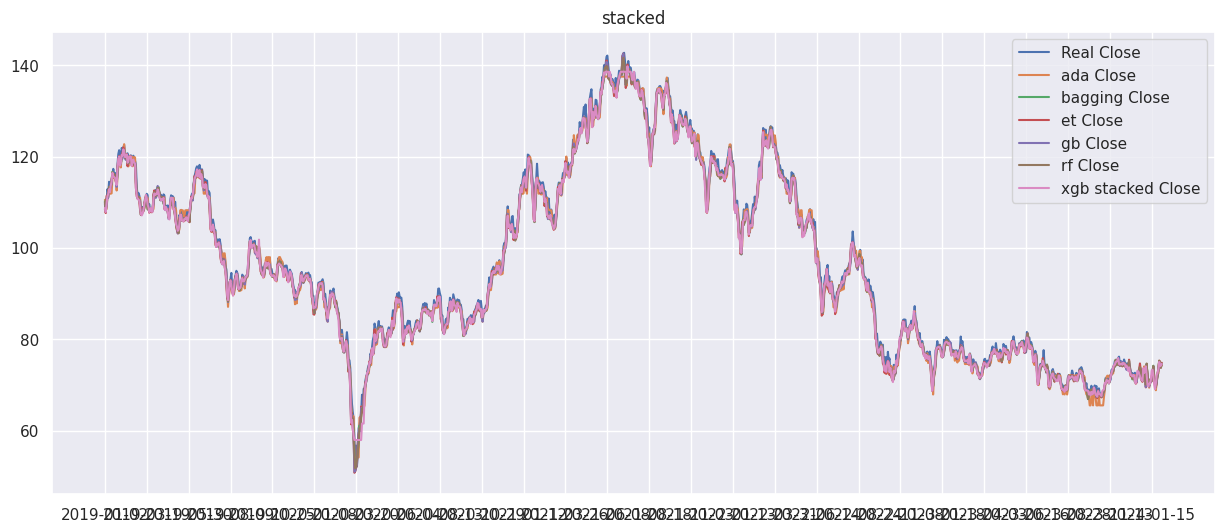

In [22]:
plt.figure(figsize = (15,6))
x_range = np.arange(df["종가"].shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df["종가"], label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(ada_list)), label = 'ada Close')
plt.plot(x_range_future, reverse_close(np.array(bagging_list)), label = 'bagging Close')
plt.plot(x_range_future, reverse_close(np.array(et_list)), label = 'et Close')
plt.plot(x_range_future, reverse_close(np.array(gb_list)), label = 'gb Close')
plt.plot(x_range_future, reverse_close(np.array(rf_list)), label = 'rf Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

In [23]:
print(reverse_close(np.array(ada_list)))

[110.53486188 108.51429078 108.51429078 ...  74.38277108  74.28813149
  74.28813149]


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 실제 주가 데이터 정의
target_length = min(len(xgb_list), len(df["종가"]))  # 예측 값과 실제 값의 최소 길이로 맞춤
real_close = df["종가"].values[-target_length:]  # 실제 데이터 슬라이싱

# 예측 값들도 실제 데이터 길이에 맞추어 슬라이싱 및 역변환
ada_pred = reverse_close(np.array(ada_list[-target_length:]))
bagging_pred = reverse_close(np.array(bagging_list[-target_length:]))
et_pred = reverse_close(np.array(et_list[-target_length:]))
gb_pred = reverse_close(np.array(gb_list[-target_length:]))
rf_pred = reverse_close(np.array(rf_list[-target_length:]))
xgb_pred = reverse_close(np.array(xgb_list[-target_length:]))

# 평가 함수 정의
def evaluate_model(predictions, real_close):
    mae = mean_absolute_error(real_close, predictions)
    mse = mean_squared_error(real_close, predictions)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# 각 모델의 평가 지표 계산
metrics = {}
models = {
    'AdaBoost': ada_pred,
    'Bagging': bagging_pred,
    'Extra Trees': et_pred,
    'Gradient Boosting': gb_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
}

for model_name, predictions in models.items():
    mae, mse, rmse = evaluate_model(predictions, real_close)
    metrics[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

# 결과 출력
for model_name, scores in metrics.items():
    print(f"{model_name} - MAE: {scores['MAE']:.4f}, MSE: {scores['MSE']:.4f}, RMSE: {scores['RMSE']:.4f}")


AdaBoost - MAE: 7.4691, MSE: 96.9041, RMSE: 9.8440
Bagging - MAE: 7.5299, MSE: 98.5060, RMSE: 9.9250
Extra Trees - MAE: 7.5852, MSE: 100.0098, RMSE: 10.0005
Gradient Boosting - MAE: 7.5076, MSE: 97.8736, RMSE: 9.8931
Random Forest - MAE: 7.5297, MSE: 98.5220, RMSE: 9.9258
XGBoost - MAE: 7.5653, MSE: 98.8897, RMSE: 9.9443
